**1 - Setup & Dataset Download**

In [2]:
!pip install kaggle
!pip install tensorflow
!pip install matplotlib
!pip install nump

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"cansugzel","key":"9bfa6094d181dbc621a28f8130115468"}'}

In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip cat-and-dog.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/training_set/training_set/cats/cat.3704.jpg  
  inflating: ./data/training_set/training_set/cats/cat.3705.jpg  
  inflating: ./data/training_set/training_set/cats/cat.3706.jpg  
  inflating: ./data/training_set/training_set/cats/cat.3707.jpg  
  inflating: ./data/training_set/training_set/cats/cat.3708.jpg  
  inflating: ./data/training_set/training_set/cats/cat.3709.jpg  
  inflating: ./data/training_set/training_set/cats/cat.371.jpg  
  inflating: ./data/training_set/training_set/cats/cat.3710.jpg  
  inflating: ./data/training_set/training_set/cats/cat.3711.jpg  
  inflating: ./data/training_set/training_set/cats/cat.3712.jpg  
  inflating: ./data/training_set/training_set/cats/cat.3713.jpg  
  inflating: ./data/training_set/training_set/cats/cat.3714.jpg  
  inflating: ./data/training_set/training_set/cats/cat.3715.jpg  
  inflating: ./data/training_set/training_set/cats/cat.3716.jpg  
  inflating: ./data/traini

**2 - Data Preprocessing**

In [6]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 42
train_dir = "data/training_set/training_set"
test_dir = "data/test_set/test_set"

# augmenter + validation_split for train
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # Allocate 20% validation from training_set

)

# Only rescale for test/validation
val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='training',
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    subset='validation',
    seed=SEED
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # shuffle False for evaluation/prediction
)

print("Train samples:", train_generator.samples)
print("Val samples:", val_generator.samples)
print("Test samples:", test_generator.samples)
print("Class indices:", train_generator.class_indices)


Found 6404 images belonging to 2 classes.
Found 1601 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Train samples: 6404
Val samples: 1601
Test samples: 2023
Class indices: {'cats': 0, 'dogs': 1}


**3 - Model Architecture**

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
base_model.trainable = False  # freeze for first step

inputs = Input(shape=IMG_SIZE + (3,))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
outputs = Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,177 (9.87 MB)

 Trainable params: 328,193 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

**4 - Training the Model**

In [8]:
from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',    # Which metric to look at: val_loss or val_accuracy
    patience=5,            # how many epochs will stop if there is no recovery
    restore_best_weights=True, # restore the best weights
    verbose=1
)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)



In [9]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=[early_stop,checkpoint]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9130 - loss: 0.2366
Epoch 1: val_loss improved from inf to 0.05375, saving model to best_model.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 125s 532ms/step - accuracy: 0.9131 - loss: 0.2361 - val_accuracy: 0.9831 - val_loss: 0.0537
Epoch 2/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9692 - loss: 0.0794
Epoch 2: val_loss improved from 0.05375 to 0.04699, saving model to best_model.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 79s 394ms/step - accuracy: 0.9692 - loss: 0.0794 - val_accuracy: 0.9844 - val_loss: 0.0470
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9763 - loss: 0.0695
Epoch 3: val_loss improved from 0.04699 to 0.04364, saving model to best_model.keras
201/201 ━━━━━━━━━━━━━━━━━━━━ 79s 393ms/step - accuracy: 0.9763 - loss: 0.0695 - val_accuracy: 0.9856 - val_loss: 0.0436
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step - accuracy: 0.9720 - loss: 0.0673
Epoch 4: val_loss improved from 0.04

**5 - Plot Performance**

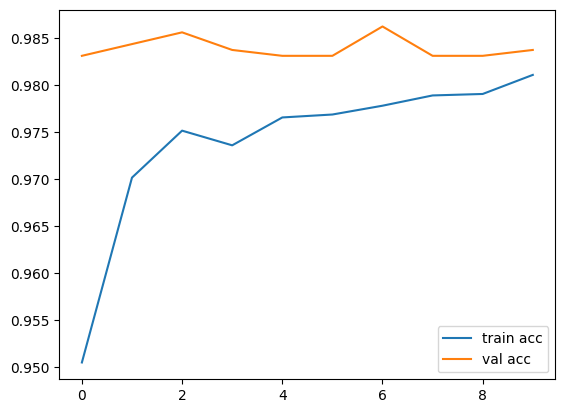

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

**6 - Evaluation on Test Set**

In [11]:
# Load the best weights
test_steps = test_generator.samples // test_generator.batch_size
if test_generator.samples % test_generator.batch_size != 0:
    test_steps += 1

model.load_weights('best_model.keras')

# Evaluate on the test set
test_results = model.evaluate(test_generator, steps=test_steps, verbose=1)

print("\nTest set sonuçları (loss, accuracy):", test_results)


64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 208ms/step - accuracy: 0.9854 - loss: 0.0499

Test set sonuçları (loss, accuracy): [0.039483655244112015, 0.9856648445129395]


In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# Predictions in the test set
pred_probs = model.predict(test_generator, steps=test_steps, verbose=1)
y_pred = (pred_probs.ravel() >= 0.5).astype(int)  # 0 or 1

# Actual labels (come in order because shuffle=False)
y_true = test_generator.classes[:len(y_pred)]

class_names = list(test_generator.class_indices.keys())

print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 128ms/step

Classification Report:
              precision    recall  f1-score   support

        cats       0.99      0.99      0.99      1011
        dogs       0.99      0.99      0.99      1012

    accuracy                           0.99      2023
   macro avg       0.99      0.99      0.99      2023
weighted avg       0.99      0.99      0.99      2023

Confusion Matrix:
[[996  15]
 [ 14 998]]


**7 - Single Image Prediction**

In [13]:
from google.colab import files

uploaded = files.upload()


Saving cat_or_dog.jpg to cat_or_dog.jpg


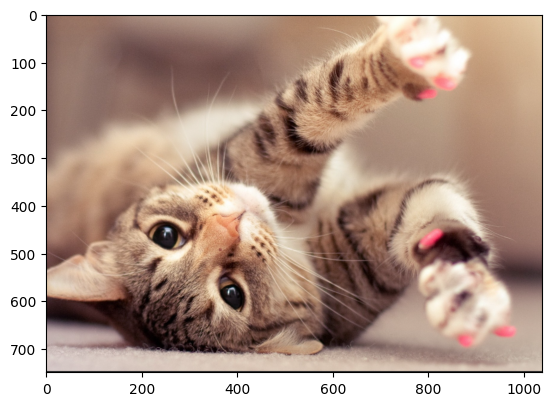

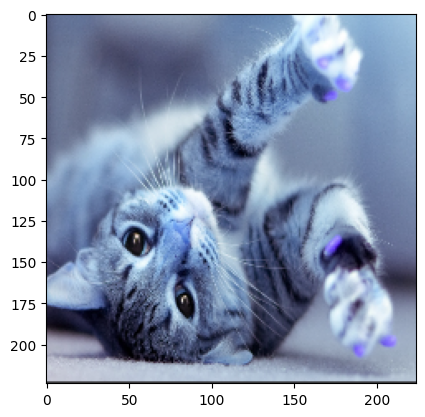

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Probability of prediction: [[0.00101352]]
Predicted class is Cat 


In [14]:
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# upload image
img = cv2.imread('cat_or_dog.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

# Resize the image
resize = tf.image.resize(img, (224,224))
plt.imshow(resize.numpy().astype(int))
plt.show()

# Predict
yhat = model.predict(np.expand_dims(resize/255, 0))
print("Probability of prediction:", yhat)

if yhat > 0.5:
    print(f'Predicted class is Dog ')
else:
    print(f'Predicted class is Cat ')


In [3]:
from google.colab import drive
drive.mount('/content/drive')
# Drive altında notebook'u ara (dosya adıyla)
!find /content/drive -maxdepth 4 -name "cat_recognition*.ipynb"


Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/cat_recognition.ipynb


In [4]:
%cd /content
!rm -rf cat-dog-classifier
!mkdir -p cat-dog-classifier/{notebooks,images,data,models}
!touch cat-dog-classifier/data/.gitkeep
!touch cat-dog-classifier/models/.gitkeep


/content


In [ ]:
# varsayım: /content/drive/MyDrive/Colab Notebooks/cat_recognition.ipynb
!cp "/content/drive/MyDrive/Colab Notebooks/cat_recognition.ipynb" /content/cat-dog-classifier/notebooks/cat_recognition.ipynb
!ls -la /content/cat-dog-classifier
